In [2]:
#run from the root directory
import os

os.chdir("..")

In [3]:
import os
import pickle as pkl
from config import *
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
DATA_DRIVE = "embeddings"
files = [file for file in os.listdir(f"./{DATA_DRIVE}/") if file.endswith(".pkl")]

### Layer Wise Embedding Analysis

In [4]:
embeddings = []
labels = []
domains = []
# for file in files:
data = pkl.load(open(f"./{DATA_DRIVE}/" + files[0], "rb"))
n = len(data['activations'][16])
# select_indices = np.random.choice(np.arange(n), min(2000, n), replace=False)
# embeddings.extend(data['activations'][16])
embeddings.extend(np.array(data['activations'][32]))
labels.extend(np.array(data['labels']))
domains.extend(np.array(data['global_labels']))
    # domains.extend([FILE_DOMAIN_MAPPING[file]] * len(data['labels']))
    # domains.extend([FILE_DOMAIN_MAPPING[file]] * len(select_indices))

embeddings = np.array(embeddings)
# labels = [index_class_mapping[x] for x in labels]

In [5]:
pca = PCA(n_components=0.95)
pca_embeddings = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

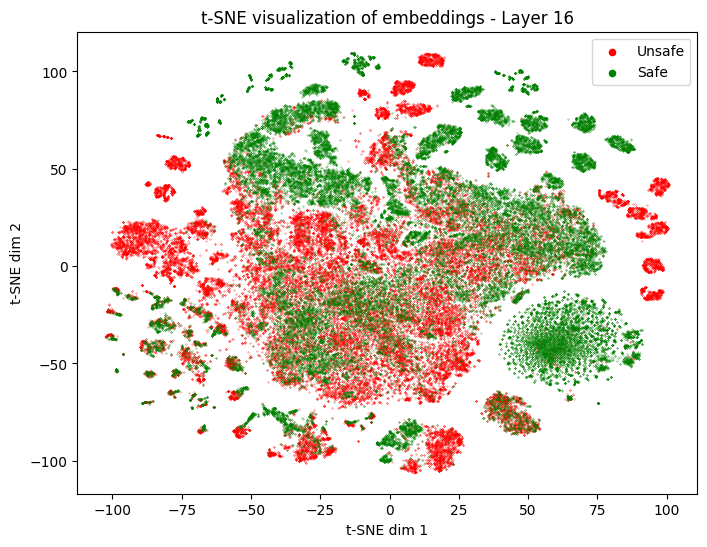

In [21]:
label2color = {0: 'red', 1: 'green'}
label2legend = {0: 'Unsafe', 1: 'Safe'}

plt.figure(figsize=(8,6))
for label in [0, 1]:
    select_indices = [i for i, x in enumerate(labels) if x == label]
    plt.scatter(tsne_embeddings[select_indices][:, 0], tsne_embeddings[select_indices][:, 1], c=label2color[label], label=label2legend[label] ,s=0.05)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.title("t-SNE visualization of embeddings - Layer 16")
plt.legend(markerscale=20)
plt.show()

In [14]:
labels = np.array(labels)

### Class wise Decision Boundary

In [6]:
DOMAINS = ["Discrimination, Exclusion, Toxicity", "HCI harms", "Malicious Uses", "Misinformation"]

In [62]:
import torch.nn as nn
class SafetyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # self.hidden_1 = nn.Linear(4096, 1024)
        # self.relu = nn.ReLU()
        # self.hidden_2 = nn.Linear(1024, 256)
        # self.hidden_3 = nn.Linear(256, 32)
        # self.output = nn.Linear(32, 1)

        self.output = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, batch):
      batch = [x.to(DEVICE) for x in batch]
      x, labels = batch
    #   x = self.relu(self.hidden_1(x))
    #   x = self.relu(self.hidden_2(x))
    #   x = self.relu(self.hidden_3(x))
      x = self.sigmoid(self.output(x))
      return x, labels
    
    def predict(self, data):
       x = torch.tensor(data, dtype=torch.float32).cuda()
       x = self.sigmoid(self.output(x))
       x = x.detach().cpu().numpy().squeeze()
       return x

In [63]:
import torch

models = []

for i in range(4):
   _model = torch.load(f"./network_weights/individual_32_{DOMAINS[i]}.pt")
   models.append(_model)

[[ 0.01466882 -0.02771598]]
[-0.31061188]
Accuracy = 0.83285
[[ 0.0164461  -0.02820988]]
[0.50932904]
Accuracy = 0.65815
[[ 0.01726278 -0.01902579]]
[0.10387138]
Accuracy = 0.5666
[[ 0.02986974 -0.04804671]]
[0.07835498]
Accuracy = 0.65635


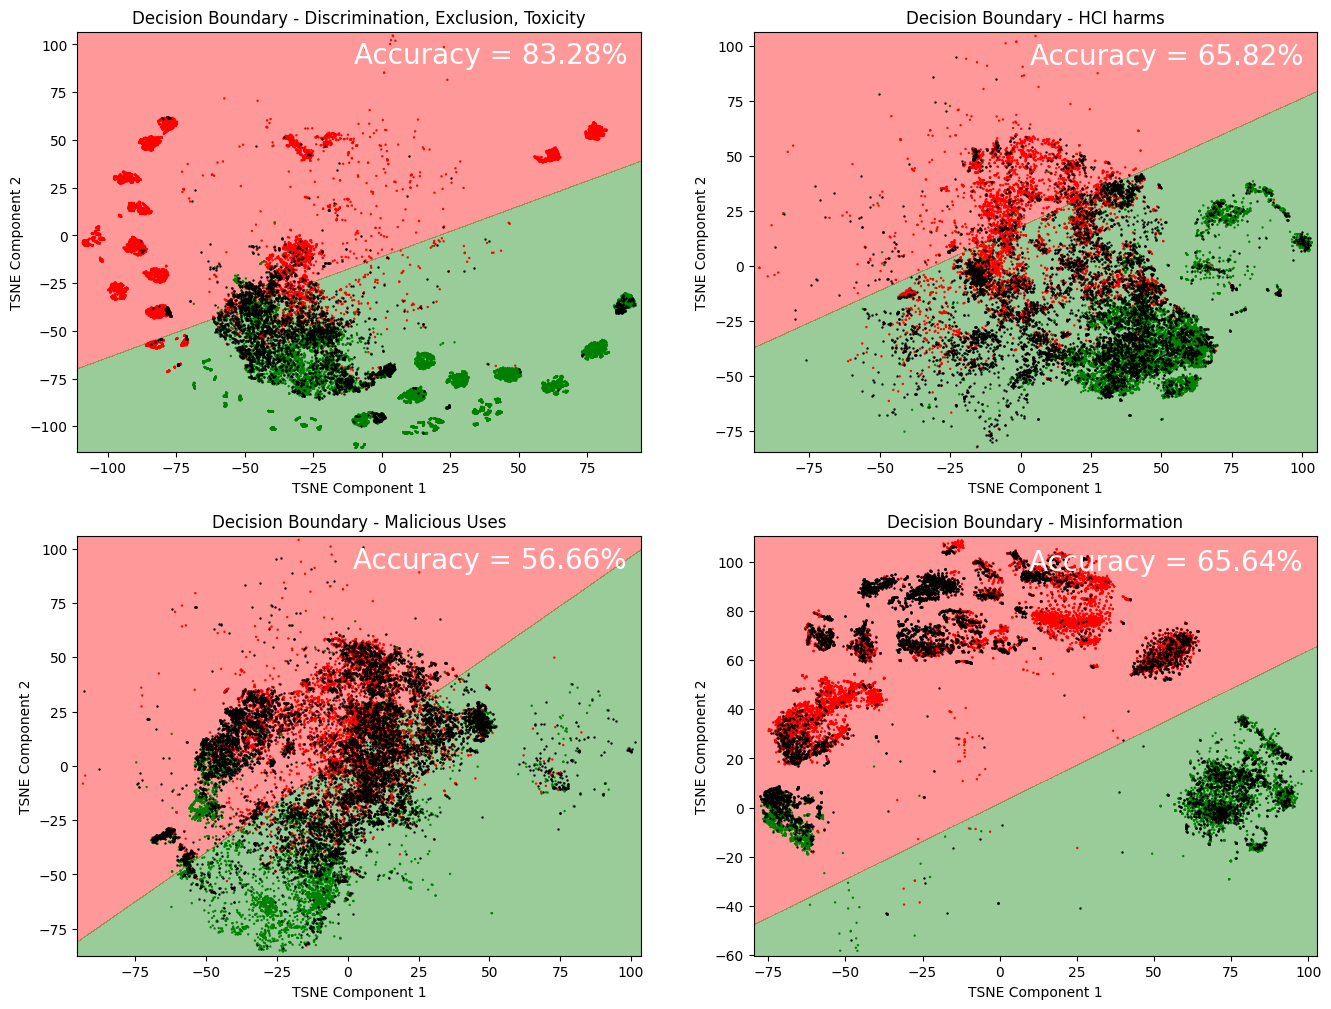

In [77]:
from sklearn.linear_model import LogisticRegression
segment_size = 20000

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axs = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]

cutoff = [0.916,	0.616, 0.489, 0.333]

for i in range(4): 
   ax = axs[i]

   start_index = i * segment_size
   end_index = start_index + segment_size

   test_data = tsne_embeddings[start_index:end_index]
   test_embeddings = embeddings[start_index:end_index]
   test_labels = labels[start_index:end_index]

   train_data = np.concatenate([tsne_embeddings[:start_index], tsne_embeddings[end_index:]])
   # train_labels = np.concatenate([labels[:start_index], labels[end_index:]])
   train_embeddings = np.concatenate([embeddings[:start_index], embeddings[end_index:]])
   train_labels = models[i].predict(train_embeddings)
   train_labels = np.where(train_labels > cutoff[i], 1, 0)

   cls = LogisticRegression(max_iter=1000)
   cls.fit(train_data, train_labels)

   print(cls.coef_)
   print(cls.intercept_)

   x_min, x_max = test_data[:, 0].min() - 2, test_data[:, 0].max() + 2
   y_min, y_max = test_data[:, 1].min() - 2, test_data[:, 1].max() + 2

   xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
   Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
   Z = Z.reshape(xx.shape)

   ax.contourf(xx, yy, Z, alpha=0.4, levels=[-1, 0, 1], colors=['red', 'green'])

   pred = models[i].predict(test_embeddings)
   pred = np.where(pred > cutoff[i], 1, 0)
   mis_classified = test_labels != pred
   cor_classified = test_labels == pred

   acc = sum(cor_classified) / len(test_labels)
   print(f"Accuracy = {sum(cor_classified) / len(test_labels)}")

   # colors = np.where(test_labels == 0, 'red', 'green')
   # ax.scatter(test_data[:, 0], test_data[:, 1], c=colors, s=0.5)
   
   colors = np.where(test_labels[cor_classified] == 0, 'red', 'green')
   ax.scatter(test_data[cor_classified][:, 0], test_data[cor_classified][:, 1], c=colors, s=0.5)
   ax.scatter(test_data[mis_classified][:, 0], test_data[mis_classified][:, 1], c='black', s=0.5)
   ptitle = f"Decision Boundary - {DOMAINS[i]}"
   ax.set_title(ptitle)
   ax.text(x_max-5, y_max-5, f"Accuracy = {np.round(100 * acc, 2)}%", fontsize=20, color='white', ha='right', va='top')
   ax.set_xlabel('TSNE Component 1')
   ax.set_ylabel('TSNE Component 2')

plt.show()

In [32]:
cls.coef_, cls.intercept_

(array([[ 0.02887437, -0.03530176]]), array([-0.5715406]))

In [28]:
global2domain = {"Discrimination, Exclusion, Toxicity": [0, 1, 2, 3, 4, 5], "HCI harms":[6, 7, 8, 9], "Malicious Uses": [10, 11, 12, 13], "Misinformation":[14, 15, 16, 17, 18]}
domain2color = {"Discrimination, Exclusion, Toxicity": 'red', "HCI harms":'green', "Malicious Uses": 'blue', "Misinformation":'orange'}

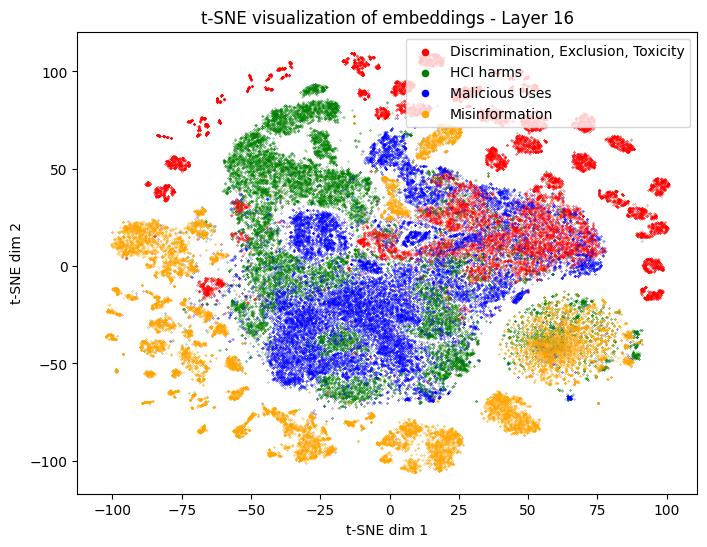

In [34]:
plt.figure(figsize=(8,6))
for domain in global2domain.keys():
    select_labels = global2domain[domain]
    select_indices = [i for i, x in enumerate(domains) if x in select_labels]
    plt.scatter(tsne_embeddings[select_indices][:, 0], tsne_embeddings[select_indices][:, 1], c=domain2color[domain], label=domain, s=0.05)
plt.legend(markerscale=20, loc='upper right')
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.title("t-SNE visualization of embeddings - Layer 16")
plt.show()

### Embedding changes across the layers

In [5]:
LAYERS = [1, 4, 8, 12, 16, 20, 24, 28, 32]

In [5]:
layer_embeddings = []
labels = []
domains = []

data = pkl.load(open(f"./{DATA_DRIVE}/" + files[0], "rb"))

labels.extend(np.array(data['labels']))
domains.extend(np.array(data['global_labels']))

start = 60000
end = 80000

for _layer in LAYERS:
    layer_embeddings.append(np.array(data['activations'][_layer][start:end]))


In [6]:
pca = PCA(n_components=0.95)
tsne = TSNE(n_components=2, random_state=0)

tsne_embeddings = []

for l in range(len(layer_embeddings)):
    pca_embeddings = pca.fit_transform(layer_embeddings[l])
    tsne_embeddings.append(tsne.fit_transform(pca_embeddings))

labels = labels[start:end]

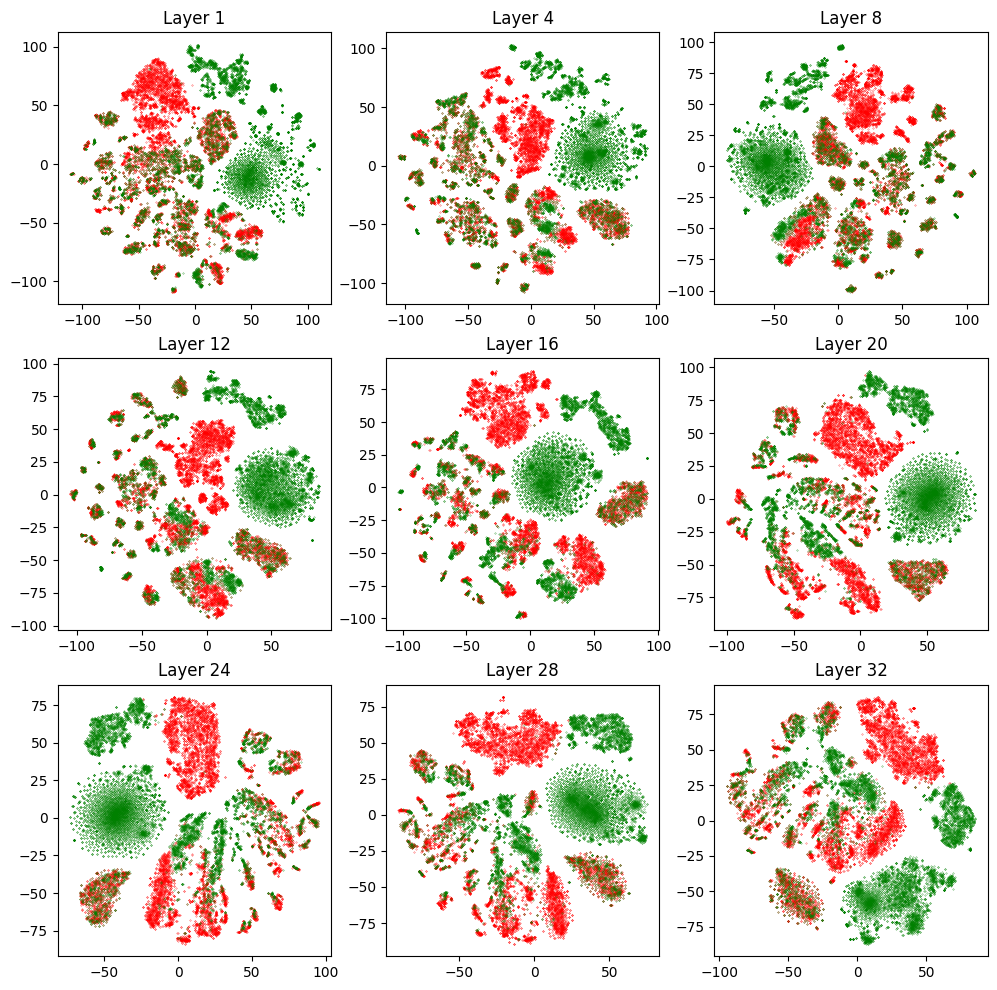

In [7]:
label2color = {0: 'red', 1: 'green'}
label2legend = {0: 'Unsafe', 1: 'Safe'}

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
# Generating random data and plotting scatter plots
for i in range(3):
    for j in range(3):
        k = i*3 + j
        x = tsne_embeddings[k][:, 0]
        y = tsne_embeddings[k][:, 1]

        for label in [0, 1]:
            select_indices = [i for i, x in enumerate(labels) if x == label]
            axes[i, j].scatter(tsne_embeddings[k][select_indices][:, 0], tsne_embeddings[k][select_indices][:, 1], c=label2color[label], label=label2legend[label] ,s=0.05)

        axes[i, j].set_title(f"Layer {LAYERS[k]}")

### Clustering Overlap

In [5]:
layer_embeddings = []
labels = []
domains = []

data = pkl.load(open(f"./{DATA_DRIVE}/" + files[0], "rb"))

labels.extend(np.array(data['labels']))
domains.extend(np.array(data['global_labels']))

for _layer in LAYERS:
    layer_embeddings.append(np.array(data['activations'][_layer]))


In [6]:
DOMAINS = ["Discrimination, Exclusion, Toxicity", "HCI harms", "Malicious Uses", "Misinformation"]

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

pca = PCA(n_components=0.95)
kmean = KMeans(n_clusters=2, random_state=0)

from collections import defaultdict
separability = defaultdict(dict)

for l in range(len(layer_embeddings)):
    for i in range(4):
        pca_embeddings = pca.fit_transform(layer_embeddings[l][i*20000:(i+1)*20000])
        pred = kmean.fit_predict(pca_embeddings)
        true = labels[i*20000:(i+1)*20000]

        acc_score = accuracy_score(true, pred)
        acc_score = max(acc_score, 1-acc_score)

        separability[DOMAINS[i]][l] = acc_score

        print(f"Layer {LAYERS[l]} {DOMAINS[i]} Accuracy: {acc_score}")

pkl.dump(separability, open("./results/separability.pkl", "wb"))

/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 1 Discrimination, Exclusion, Toxicity Accuracy: 0.53


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 1 HCI harms Accuracy: 0.57045


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 1 Malicious Uses Accuracy: 0.5002


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 1 Misinformation Accuracy: 0.68405


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 4 Discrimination, Exclusion, Toxicity Accuracy: 0.53835


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 4 HCI harms Accuracy: 0.5765


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 4 Malicious Uses Accuracy: 0.51545


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 4 Misinformation Accuracy: 0.69965


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 8 Discrimination, Exclusion, Toxicity Accuracy: 0.54195


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 8 HCI harms Accuracy: 0.5768


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 8 Malicious Uses Accuracy: 0.50075


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 8 Misinformation Accuracy: 0.70005


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 12 Discrimination, Exclusion, Toxicity Accuracy: 0.5314


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 12 HCI harms Accuracy: 0.57675


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 12 Malicious Uses Accuracy: 0.5516


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 12 Misinformation Accuracy: 0.69985


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 16 Discrimination, Exclusion, Toxicity Accuracy: 0.5501


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 16 HCI harms Accuracy: 0.57655


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 16 Malicious Uses Accuracy: 0.5007


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 16 Misinformation Accuracy: 0.6997


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 20 Discrimination, Exclusion, Toxicity Accuracy: 0.8033


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 20 HCI harms Accuracy: 0.57675


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 20 Malicious Uses Accuracy: 0.6597999999999999


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 20 Misinformation Accuracy: 0.69975


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 24 Discrimination, Exclusion, Toxicity Accuracy: 0.8066


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 24 HCI harms Accuracy: 0.57685


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 24 Malicious Uses Accuracy: 0.6675


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 24 Misinformation Accuracy: 0.69985


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 28 Discrimination, Exclusion, Toxicity Accuracy: 0.80775


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 28 HCI harms Accuracy: 0.57685


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 28 Malicious Uses Accuracy: 0.6744


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 28 Misinformation Accuracy: 0.69985


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 32 Discrimination, Exclusion, Toxicity Accuracy: 0.80865


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 32 HCI harms Accuracy: 0.5769500000000001


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 32 Malicious Uses Accuracy: 0.67465


/nethome/ss651/miniconda3/envs/dlt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Layer 32 Misinformation Accuracy: 0.70005


In [7]:
from sklearn.metrics import silhouette_score

pca = PCA(n_components=0.95)

from collections import defaultdict
ss = defaultdict(dict)

for l in range(len(layer_embeddings)):
    for i in range(4):
        pca_embeddings = pca.fit_transform(layer_embeddings[l][i*20000:(i+1)*20000])
        true = labels[i*20000:(i+1)*20000]

        ss_score = silhouette_score(pca_embeddings, true)

        ss[DOMAINS[i]][l] = ss_score

        print(f"Layer {LAYERS[l]} {DOMAINS[i]} Accuracy: {ss_score}")

Layer 1 Discrimination, Exclusion, Toxicity Accuracy: 0.020175928444020365
Layer 1 HCI harms Accuracy: 0.10745646943560128
Layer 1 Malicious Uses Accuracy: 0.00902352041382003
Layer 1 Misinformation Accuracy: 0.1750366235612677
Layer 4 Discrimination, Exclusion, Toxicity Accuracy: 0.02793960753631052
Layer 4 HCI harms Accuracy: 0.08341357896734986
Layer 4 Malicious Uses Accuracy: 0.010965115353806785
Layer 4 Misinformation Accuracy: 0.14829290206755544
Layer 8 Discrimination, Exclusion, Toxicity Accuracy: 0.02652508543992027
Layer 8 HCI harms Accuracy: 0.09465118227931012
Layer 8 Malicious Uses Accuracy: 0.01236645619820338
Layer 8 Misinformation Accuracy: 0.1536297709023552
Layer 12 Discrimination, Exclusion, Toxicity Accuracy: 0.09869801502533605
Layer 12 HCI harms Accuracy: 0.09818059553547388
Layer 12 Malicious Uses Accuracy: 0.024977993859730728
Layer 12 Misinformation Accuracy: 0.1609223391882893
Layer 16 Discrimination, Exclusion, Toxicity Accuracy: 0.18084208175972202
Layer 16 

In [8]:
ss

defaultdict(dict,
            {'Discrimination, Exclusion, Toxicity': {0: 0.020175928444020365,
              1: 0.02793960753631052,
              2: 0.02652508543992027,
              3: 0.09869801502533605,
              4: 0.18084208175972202,
              5: 0.19606965902925075,
              6: 0.19744569249133537,
              7: 0.1991326506666657,
              8: 0.18397079891458587},
             'HCI harms': {0: 0.10745646943560128,
              1: 0.08341357896734986,
              2: 0.09465118227931012,
              3: 0.09818059553547388,
              4: 0.10877443961302631,
              5: 0.13069869284894367,
              6: 0.1376693188122932,
              7: 0.13243832105232295,
              8: 0.12587614989690718},
             'Malicious Uses': {0: 0.00902352041382003,
              1: 0.010965115353806785,
              2: 0.01236645619820338,
              3: 0.024977993859730728,
              4: 0.03818771312475887,
              5: 0.0522446410149542

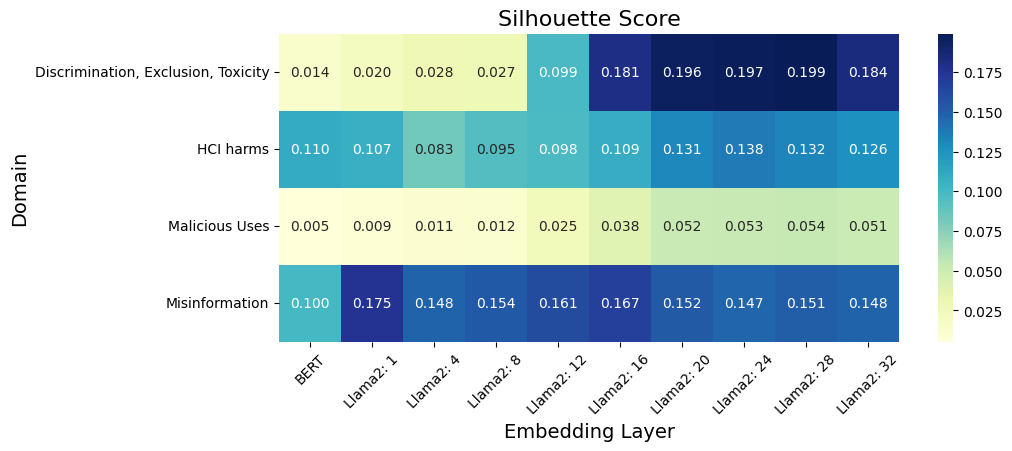

In [25]:
hmap = []
bert = [0.014, 0.11, 0.0053, 0.1]
for i, domain in enumerate(DOMAINS):
    v = [bert[i]] + [ss[domain][l] for l in range(len(LAYERS))]
    hmap.append(v)


import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(hmap, annot=True, ax=ax, xticklabels=['BERT'] + ["Llama2: " + str(x) for x in LAYERS], fmt=".3f", yticklabels=DOMAINS, cmap="YlGnBu")
plt.xlabel("Embedding Layer", fontsize=14)
plt.ylabel("Domain", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Silhouette Score", fontsize=16)
plt.show()

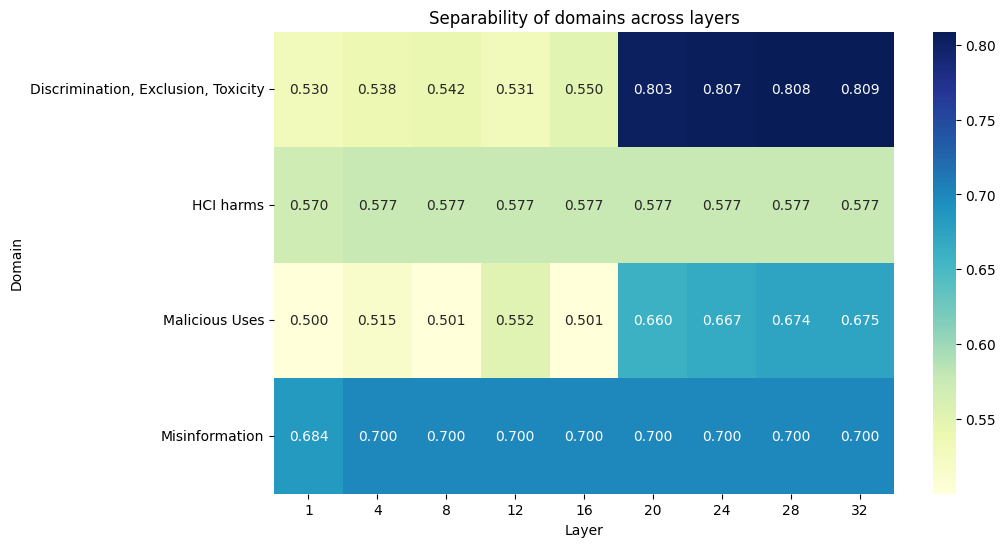

In [34]:
hmap = []
for domain in DOMAINS:
    hmap.append([separability[domain][l] for l in range(len(LAYERS))])


import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(hmap, annot=True, ax=ax, xticklabels=LAYERS, yticklabels=DOMAINS, cmap="YlGnBu", fmt=".3f")
plt.xlabel("Layer")
plt.ylabel("Domain")
plt.title("Separability of domains across layers")
plt.show()